## Chapter 9. 비지도 학습

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 9.1 Cluster

In [3]:
# 예제 데이터 생성
from sklearn.datasets import make_blobs
import numpy as np

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

In [4]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

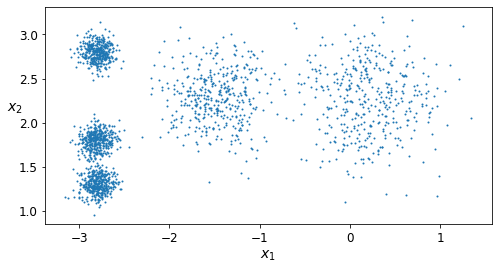

In [5]:

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [6]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=2022)
y_pred = kmeans.fit_predict(X)
y_pred

array([2, 4, 0, ..., 1, 0, 4])

In [7]:
y_pred is kmeans.labels_

True

In [8]:
# centroid
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

In [9]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 1, 1])

#### Plot k-Means Decision boundary

In [10]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

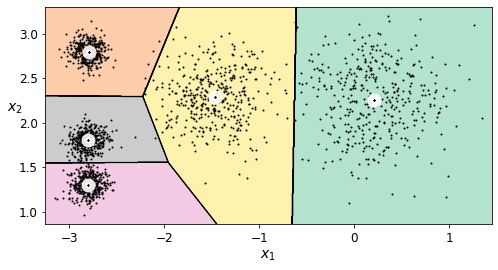

In [11]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [12]:
# 하드 군집 vs 소프트 군집
# 하드 군집은 각 샘플에 대해 가장 가까운 클러스터를 선택하는데, 이 대신 샘플에서 5개 센트로이드까지 거리를 측정하는 것이 나을 수 있음
# transform() 메서드에서 이 거리를 계산
kmeans.transform(X_new)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

In [13]:
# 위 거리가 샘플과 센트로이드 사이의 유클리드 거리인지 확인
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[0.32995317, 2.9042344 , 2.88633901, 1.49439034, 2.81093633],
       [2.80290755, 5.84739223, 5.84236351, 4.4759332 , 5.80730058],
       [3.29399768, 0.29040966, 1.71086031, 1.69136631, 1.21475352],
       [3.21806371, 0.36159148, 1.21567622, 1.54808703, 0.72581411]])

In [14]:
# 센트로이드 초기화 방법
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

In [15]:
# KMeans 이너셔 확인
kmeans.inertia_

211.59853725816836

In [16]:
# 좋은 결과물일수록 높은 수가 되어야 하므로, 음수값으로 처리됨
kmeans.score(X)

-211.59853725816836

In [17]:
# k-평균 속도 개선과 미니배치 k-평균
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5)

In [18]:
# 최적의 클러스터 개수 정하기
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [19]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
                
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

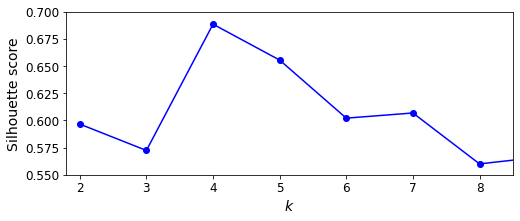

In [20]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

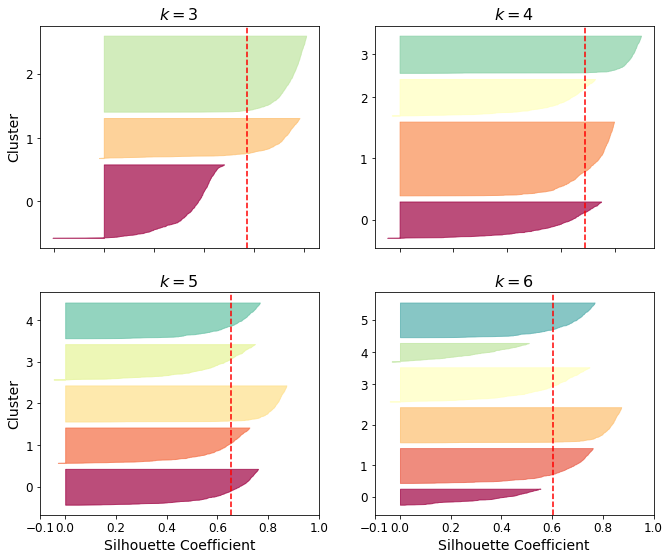

In [21]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

#### 군집을 사용한 이미지 분할

In [22]:
# 무당벌레 이미지를 다운로드
import urllib.request
import os

PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x1ce30574370>)

In [23]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [26]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [27]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

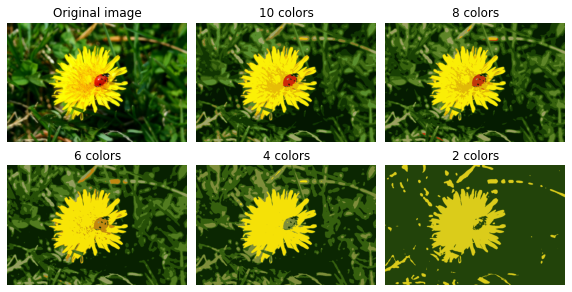

In [28]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')
plt.show()

#### 군집을 사용한 전처리

In [32]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [34]:
from sklearn.linear_model import LogisticRegression
import warnings; warnings.filterwarnings('ignore')

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_reg.score(X_test, y_test)

0.9577777777777777

In [35]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('kmeans', KMeans(n_clusters=50)),
    ('log_reg', LogisticRegression())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression())])

In [36]:
pipeline.score(X_test, y_test)

0.96

In [37]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.2s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                                       ('log_reg', LogisticRegression())]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [38]:
grid_clf.best_params_

{'kmeans__n_clusters': 87}

In [39]:
grid_clf.score(X_test, y_test)

0.96

#### 군집을 사용한 준지도 학습

In [53]:
n_labeled = 50
log_reg = LogisticRegression(random_state=2023)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(random_state=2023)

In [54]:
log_reg.score(X_test, y_test)

0.8266666666666667

In [55]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

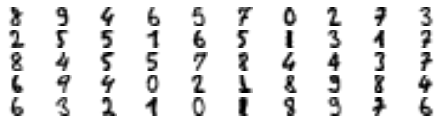

In [56]:
# 대표 이미지를 출력하고 수동으로 레이블을 매김
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show()

In [57]:
y_train[representative_digit_idx]

array([8, 9, 4, 6, 5, 7, 0, 2, 7, 3, 2, 5, 5, 1, 6, 5, 1, 3, 1, 7, 8, 4,
       5, 5, 7, 8, 4, 4, 3, 7, 6, 9, 4, 0, 2, 1, 8, 9, 8, 4, 6, 3, 2, 1,
       0, 1, 8, 9, 7, 6])

In [59]:
y_representative_digits = np.array([
    8, 9, 4, 6, 5, 7, 0, 2, 7, 3,
    2, 5, 5, 1, 6, 5, 1, 3, 1, 7,
    8, 4, 5, 5, 7, 8, 4, 4, 3, 7,
    6, 9, 4, 0, 2, 2, 8, 9, 8, 4,
    6, 3, 2, 1, 0, 8, 8, 9, 7, 6])

In [60]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8866666666666667

In [61]:
# 레이블 전파
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [65]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8977777777777778

In [70]:
# 센트로이드 인근에만 레이블 전파
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [71]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=2023)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9

In [72]:
# 전파된 레이블과 실제 레이블의 유사도
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9443892750744787

#### DBSCAN